# Iterative Interaction Flux Balance Analysis (IIFBA)
This code is a development environment for the IIFBA code.

Iterative interaction FBA (IIFBA) simulates interactions between microbial organisms using an efficient iterative framework to capture competition and cross-feeding interactions.

## Equations

#### Indexed Version:
Original conceptualization of IIFBA equation

$\large{f_{n+1,j}=(1-\alpha)[f_{n,j}-\sum_{i} R_{i} F_{n,i,j}(f_{n,j},S_i)]+\alpha f_{0,j}}$

* Variables:
    * $f_{n,j}$: the exchange flux bound for j-th metabolite in n-th environment iteration
    * $R_{i}$: relative abundance of i-th organism
    * $F_{n,i,j}$: exchange flux of i-th organism for j-th metablite simulated in environment iteration n, as a function of the exchange flux bounds and metabolic model $S_i$
* Parameters:
    * $\alpha$: flow factor (trade-off between updated and original environment)
* Input:
    * $f_{0,j}$: exchange flux bounds for j-th metabolite in initial environment
    * $R$: relative abundance vector
    * $S$: metabolic models
* Output:
    * F: flux list with matrix of fluxes by iteration for each organism
    * f: environment fluxes, matrix of exchange fluxes by iteration

#### Matrix Version:
Vectorized form of the IIFBA equation

$\large{f_{n+1}=(1-\alpha)[f_{n}- R F_{n}(f_{n},S)]+\alpha f_{0}}$

* Matrix Variables:
    * $f_{n}$: vector of exchange flux bounds for all metabolites in n-th environment iteration
    * $R$: vector of relative abundances for all organisms
    * $F_{n}$: matrix of organisms by exchanges for  fluxes simulated in n-th environment iteration as a function of the exchange flux bounds and organism metabolic models $S$
* Parameters:
    * $\alpha$: flow factor (trade-off between updated and original environment)
* Input:
    * $f_{0}$: exchange flux bounds vector for initial environment
    * $R$: relative abundance vector
* Output:
    * F: flux list with matrix of fluxes by iteration for each organism
    * f: environment fluxes, matrix of exchange fluxes by iteration

#### Sampling Indexed Version:
This version of the equation includes multiple runs of flux simulation (for example: flux sampling). Two new parameters are introduced ($m1$ and $m2$) to control the sampling process. Note that the runs must be randomly down sampled at each itteration to avoid an exponential explosion of flux calculations.

$\large{f_{n+1,j,m}=(1-\alpha)[f_{n,j,M_n}-\sum_{i} R_{i} F_{n,i,j,m}(f_{n,j,M_n},S_i)]+\alpha f_{0,j}}$

* Variables:
    * $f_{n,j,m}$: the exchange flux bound for j-th metabolite in n-th environment iteration, for the m-th run
    * $f_{n,j,M_n}$ the exchange flux bound for the j-th metabolite in the n-th environment iteration for the initial point mapped by the $M$ matrix for the n-th iteration
    * $R_{i}$: relative abundance of i-th organism
    * $F_{n,i,j}$: exchange flux of i-th organism for j-th metablite simulated in environment iteration n, for flux run m as a function of the exchange flux bounds and organism metabolic model $S_i$
* Parameters:
    * $\alpha$: flow factor (trade-off between updated and original environment)
    * $m1$: number of initial points to use at each iteration
    * $m2$: number of flux runs per initial point (Note: the total number of flux runs at each iteration will be equal to $m1*m2=m$)
    * M: initial point mapping matrix that of m (flux runs) by n (iterations) that maps the initial point from the previous iteration for each flux run
* Input:
    * $f_{0,j}$: exchange flux bounds for j-th metabolite in initial environment
    * $R$: relative abundance vector
* Output:
    * F: flux list with matrix of fluxes by iteration and sample for each organism
    * f: environment fluxes, matrix of exchange fluxes by iteration

#### Sampling Matrix Version:
This version of the equation includes multiple runs of flux simulation (for example: flux sampling). Two new parameters are introduced ($m1$ and $m2$) to control the sampling process. Note that the runs must be randomly down sampled at each itteration to avoid an exponential explosion of flux calculations.

$\large{f_{n+1,m}=[1-\alpha][f_{n,M_n}- R F_{n,m}(f_{n,M_n},S)]+\alpha f_{0}}$

* Matrix Variables:
    * $f_{n,m}$: vector of exchange flux bounds for all metabolites in n-th environment iteration and m-th run
    * $f_{n,M_n}$ the exchange flux bounds for all metabolites in the n-th environment iteration for the initial point mapped by the $M$ matrix for the n-th iteration
    * $R$: vector of relative abundances for all organisms
    * $F_{n}$: matrix of organisms by exchanges for  fluxes simulated in n-th environment iteration as a function of the exchange flux bounds and organism metabolic models $S$
* Parameters:
    * $\alpha$: flow factor (trade-off between updated and original environment)
    * $m1$: number of initial points to use at each iteration
    * $m2$: number of flux runs per initial point (Note: the total number of flux runs at each iteration will be equal to $m1*m2=m$)
    * M: initial point mapping matrix that of m (flux runs) by n (iterations) that maps the initial point from the previous iteration for each flux run
* Input:
    * $f_{0}$: exchange flux bounds vector for initial environment
    * $R$: relative abundance vector
* Output:
    * F: flux list with matrix of fluxes by iteration and sample for each organism
    * f: environment fluxes, matrix of exchange fluxes by iteration


## Code

### Example 1: Self Interaction

In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import cobra as cb
import numpy as np
import pandas as pd

In [3]:
# model_pre_processing
#mod_paths = ['/Users/david/Dropbox/My_Stuff/UVM_2/Lab/Projects/AGORA2_Metabolic_Models/AGORA2_annotatedMat_D_F/Escherichia_coli_str_K_12_substr_MG1655.mat']
mod_paths = ['../AGORA2_Models/Escherichia_coli_str_K_12_substr_MG1655.mat']#
S = [] #list of models
# Load Models and Save in S vector
for i in range(len(mod_paths)):
    model = cb.io.load_matlab_model(mod_paths[i])
    S.append(model) #append models to list

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [4]:
# Define input environment f_0
# this should be defined as a pandas dataframe with columns "Reaction" and "LB"
# glucose minimal medium
# Define Medium Components
glc_min_med = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_no3(e)','EX_pi(e)','EX_cys_L(e)',
               'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)','EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
glc_min_med_flux = [-10,-100,-100,-100,-100,-100,
                    -100,-100,-100,-100,-100,-100,-100,-100,-100,-100]
glc_f0 = pd.DataFrame(data={'Reaction': glc_min_med,'LB': glc_min_med_flux})

In [5]:
# iterative fba (sampling or non-sampling)
# input/parameters
sol_fun = 'pfba' #sampling or pfba. If pfba, m1 and m2 = 1
f_0 = glc_f0
n = 10 # number of iterations
m1 = 1 # number of initial points to use at each iteration
m2 = 1 # number of runs
M = np.zeros([m1,n-1],dtype=int) #randomly pre-assign sampling initial point matrix
for i in range(n-1):
    Mcol = np.sort(np.random.choice(m1*m2,m1,replace=False))
    M[:,i]=Mcol
alpha = 0.5
R = [1]

# Function
# output
# initialize environment flux dataframe
# Index
arrays = [[0]*m1*m2,list(range(m1*m2))]
tuples = list(zip(*arrays))
multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
# Columns
cols = set()
for ii in range(len(S)):
    for ji in range(len(S[ii].exchanges)):
        cols.add(S[ii].exchanges[ji].id)
f = pd.DataFrame([np.zeros(len(cols))],columns=list(cols),index=multi_idx,dtype=float)
for ji in range(len(f_0)):
    exid = f_0.iloc[ji]['Reaction']
    ex_flux = f_0.iloc[ji]['LB']
    f.loc[:,exid] = ex_flux

# initialize organism flux dataframes
F = []

for ni in range(n): #iteration
    print('iteration:',ni)
    if ni == 0: #first iteration
        # run fba for each model in environment n
        for ii in range(len(S)):
            print('organism:',ii)
            with S[ii] as model_t: #get model from list of models S
                # Re-set Exchanges (just to be safe)
                for ex in model_t.exchanges:
                    ex.lower_bound = 0
                    ex.upper_bound = 1000
                # Set Environment
                for exi in range(len(f.columns)):
                    ex_lb = f.loc[(0,0)][f.columns[exi]] #initial environment is the same for all runs, so use the 0th run
                    if ex_lb != 0:
                        ex_id = f.columns[exi]
                        if ex_id in model_t.exchanges:
                            model_t.exchanges.get_by_id(ex_id).lower_bound = ex_lb

                if sol_fun == 'pfba':
                    multi_idx = pd.MultiIndex.from_tuples([(0,0)],names=["iteration","run"])                                       
                    # run pFBA
                    sol1 = model_t.slim_optimize()
                    if sol1 > 0.001:
                        sol = cb.flux_analysis.parsimonious.pfba(model_t)
                        # standardize and save output                   
                        df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                        F.append(df)
                    else:
                        rxnid = []
                        for i in range(len(S[ii].reactions)): rxnid.append(S[ii].reactions[i].id)
                        df = pd.DataFrame([np.zeros(len(S[ii].reactions))],columns=rxnid,index=multi_idx)
                        F.append(df)
                
                if sol_fun == 'sampling':
                    # run flux sampling
                    sol = cb.sampling.sample(model_t,m1*m2)
                    # standardize and save output
                    arrays = [[0]*m1*m2,list(sol.index)]
                    tuples = list(zip(*arrays))
                    multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                    sol.index = multi_idx
                    F.append(sol)
            
        # update f
        for mi in range(m1*m2): 
            df_t = f.loc[[(0,0)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
            for ji in range(len(f.columns)):# for each exchange flux in environment
                i_sum = 0
                flux_id = f.columns[ji]
                for ii in range(len(S)):# for each organism sum up flux * relative abundance
                    if flux_id in S[ii].exchanges:
                        if F[ii].loc[(0,mi)][flux_id] != 0:
                            i_sum = i_sum + F[ii].loc[(0,mi)][flux_id] * R[ii]
                df_t.loc[(0,0),flux_id] = (1-alpha)*(f.loc[(0,0)][flux_id].item()-i_sum) + alpha*f.loc[(0,0)][flux_id].item() # update flux
            #re-index tmp dataframe
            multi_idx = pd.MultiIndex.from_tuples([(1,mi)],names=["iteration","run"])
            df_tt = pd.DataFrame([df_t.loc[(0,0)]],columns = df_t.columns, index = multi_idx)
            f = pd.concat([f,df_tt])

    else:
        for m1i in range(m1): #run with different initial points       
            # run fba for each model in environment n set by M matrix
            Mi = M[m1i,ni-1] #mapping
            for ii in range(len(S)):
                print('organism:',ii)
                with S[ii] as model_t: #get model from list of models S
                    # Re-set Exchanges (just to be safe)
                    for ex in model_t.exchanges:
                        ex.lower_bound = 0
                        ex.upper_bound = 1000
                    # Set Environment
                    for exi in range(len(f.columns)):
                        ex_lb = f.loc[(ni,Mi)][f.columns[exi]]
                        if ex_lb != 0:
                            ex_id = f.columns[exi]
                            if ex_id in model_t.exchanges:
                                model_t.exchanges.get_by_id(ex_id).lower_bound = ex_lb
    
                    if sol_fun == 'pfba':
                        multi_idx = pd.MultiIndex.from_tuples([(ni,0)],names=["iteration","run"])
                        # run pFBA
                        sol1 = model_t.slim_optimize()
                        if sol1 > 0.001:
                            sol = cb.flux_analysis.parsimonious.pfba(model_t)
                            # standardize and save output                   
                            df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                            F[ii] = pd.concat([F[ii],df])
                        else:
                            rxnid = []
                            for i in range(len(S[ii].reactions)): rxnid.append(S[ii].reactions[i].id)
                            df = pd.DataFrame([np.zeros(len(S[ii].reactions))],columns=rxnid,index=multi_idx)
                            F[ii] = pd.concat([F[ii],df])
                            
                    if sol_fun == 'sampling':
                        # run flux sampling
                        sol = cb.sampling.sample(model_t,m2)
                        # standardize and save output
                        arrays = [[ni]*m1*m2,list(sol.index+m1i*m2)]
                        tuples = list(zip(*arrays))
                        multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                        sol.index = multi_idx
                        F[ii] = pd.concat([F[ii],sol])

            # update f
            for m2i in range(m2):
                df_t = f.loc[[(ni,Mi)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
                for ji in range(len(f.columns)):# for each exchange flux in environment
                    i_sum = 0
                    flux_id = f.columns[ji]
                    for ii in range(len(S)):# for each organism sum up flux * relative abundance
                        if flux_id in S[ii].exchanges:
                            if F[ii].loc[(ni,m2i+m1i*m2)][flux_id] != 0:
                                i_sum = i_sum + F[ii].loc[(ni,m2i+m1i*m2)][flux_id] * R[ii]
                    df_t.loc[(ni,Mi),flux_id] = (1-alpha)*(f.loc[(ni,Mi)][flux_id].item()-i_sum) + alpha*f.loc[(0,0)][flux_id].item() # update flux
                #re-index tmp dataframe
                multi_idx = pd.MultiIndex.from_tuples([(ni+1,m2i+m1i*m2)],names=["iteration","run"])
                df_tt = pd.DataFrame([df_t.loc[(ni,Mi)]],columns = df_t.columns, index = multi_idx)
                f = pd.concat([f,df_tt])

iteration: 0
organism: 0
iteration: 1
organism: 0
iteration: 2
organism: 0
iteration: 3
organism: 0
iteration: 4
organism: 0
iteration: 5
organism: 0
iteration: 6
organism: 0
iteration: 7
organism: 0
iteration: 8
organism: 0
iteration: 9
organism: 0


In [8]:
f['EX_glc_D(e)']

iteration  run
0          0     -10.0
1          0      -5.0
2          0      -5.0
3          0      -5.0
4          0      -5.0
5          0      -5.0
6          0      -5.0
7          0      -5.0
8          0      -5.0
9          0      -5.0
10         0      -5.0
Name: EX_glc_D(e), dtype: float64

In [9]:
f['EX_ac(e)']

iteration  run
0          0      0.0
1          0      0.0
2          0      0.0
3          0      0.0
4          0      0.0
5          0      0.0
6          0      0.0
7          0      0.0
8          0      0.0
9          0      0.0
10         0      0.0
Name: EX_ac(e), dtype: float64

In [10]:
F[0]['biomass525']

iteration  run
0          0      0.784637
1          0      0.392319
2          0      0.392319
3          0      0.392319
4          0      0.392319
5          0      0.392319
6          0      0.392319
7          0      0.392319
8          0      0.392319
9          0      0.392319
Name: biomass525, dtype: float64

In [11]:
F[0]['EX_glc_D(e)']

iteration  run
0          0     -10.0
1          0      -5.0
2          0      -5.0
3          0      -5.0
4          0      -5.0
5          0      -5.0
6          0      -5.0
7          0      -5.0
8          0      -5.0
9          0      -5.0
Name: EX_glc_D(e), dtype: float64

In [12]:
F[0]['EX_ac(e)']

iteration  run
0          0      0.0
1          0      0.0
2          0      0.0
3          0      0.0
4          0      0.0
5          0      0.0
6          0      0.0
7          0      0.0
8          0      0.0
9          0      0.0
Name: EX_ac(e), dtype: float64

In [13]:
# Save F and f with pickle
import pickle
with open('Ff_single.pkl', 'wb') as file:
    pickle.dump([F,f], file)


### Example 2: Pairwise Interaction

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [15]:
import cobra as cb
import numpy as np
import pandas as pd

In [16]:
# model_pre_processing
mod_paths = ['/Users/david/Dropbox/My_Stuff/UVM_2/Lab/Projects/AGORA2_Metabolic_Models/AGORA2_annotatedMat_D_F/Escherichia_coli_str_K_12_substr_MG1655.mat',
             '/Users/david/Dropbox/My_Stuff/UVM_2/Lab/Projects/AGORA2_Metabolic_Models/AGORA2_annotatedMat_A_C/Bacteroides_thetaiotaomicron_3731.mat']
S = [] #list of models
# Load Models and Save in S vector
for i in range(len(mod_paths)):
    model = cb.io.load_matlab_model(mod_paths[i])
    S.append(model) #append models to list

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [17]:
# Define input environment f_0
# this should be defined as a pandas dataframe with columns "Reaction" and "LB"
# glucose minimal medium
# Define Medium Components
glc_min_med = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_no3(e)','EX_pi(e)','EX_cys_L(e)',
               'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)','EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
glc_min_med_flux = [-10,-100,-100,-100,-100,-100,
                    -100,-100,-100,-100,-100,-100,-100,-100,-100,-100]
glc_f0 = pd.DataFrame(data={'Reaction': glc_min_med,'LB': glc_min_med_flux})

In [18]:
# iterative fba (sampling or non-sampling)
# input/parameters
sol_fun = 'pfba' #sampling or pfba. If pfba, m1 and m2 = 1
f_0 = glc_f0
n = 10 # number of iterations
m1 = 1 # number of initial points to use at each iteration
m2 = 1 # number of runs
M = np.zeros([m1,n-1],dtype=int) #randomly pre-assign sampling initial point matrix
for i in range(n-1):
    Mcol = np.sort(np.random.choice(m1*m2,m1,replace=False))
    M[:,i]=Mcol
alpha = 0.5
R = [0.5,0.5]

# Function
# output
# initialize environment flux dataframe
# Index
arrays = [[0]*m1*m2,list(range(m1*m2))]
tuples = list(zip(*arrays))
multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
# Columns
cols = set()
for ii in range(len(S)):
    for ji in range(len(S[ii].exchanges)):
        cols.add(S[ii].exchanges[ji].id)
f = pd.DataFrame([np.zeros(len(cols))],columns=list(cols),index=multi_idx,dtype=float)
for ji in range(len(f_0)):
    exid = f_0.iloc[ji]['Reaction']
    ex_flux = f_0.iloc[ji]['LB']
    f.loc[:,exid] = ex_flux

# initialize organism flux dataframes
F = []

for ni in range(n): #iteration
    print('iteration:',ni)
    if ni == 0: #first iteration
        # run fba for each model in environment n
        for ii in range(len(S)):
            print('organism:',ii)
            with S[ii] as model_t: #get model from list of models S
                # Re-set Exchanges (just to be safe)
                for ex in model_t.exchanges:
                    ex.lower_bound = 0
                    ex.upper_bound = 1000
                # Set Environment
                for exi in range(len(f.columns)):
                    ex_lb = f.loc[(0,0)][f.columns[exi]] #initial environment is the same for all runs, so use the 0th run
                    if ex_lb != 0:
                        ex_id = f.columns[exi]
                        if ex_id in model_t.exchanges:
                            model_t.exchanges.get_by_id(ex_id).lower_bound = ex_lb

                if sol_fun == 'pfba':
                    multi_idx = pd.MultiIndex.from_tuples([(0,0)],names=["iteration","run"])                                       
                    # run pFBA
                    sol1 = model_t.slim_optimize()
                    if sol1 > 0.001:
                        sol = cb.flux_analysis.parsimonious.pfba(model_t)
                        # standardize and save output                   
                        df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                        F.append(df)
                    else:
                        rxnid = []
                        for i in range(len(S[ii].reactions)): rxnid.append(S[ii].reactions[i].id)
                        df = pd.DataFrame([np.zeros(len(S[ii].reactions))],columns=rxnid,index=multi_idx)
                        F.append(df)
                
                if sol_fun == 'sampling':
                    # run flux sampling
                    sol = cb.sampling.sample(model_t,m1*m2)
                    # standardize and save output
                    arrays = [[0]*m1*m2,list(sol.index)]
                    tuples = list(zip(*arrays))
                    multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                    sol.index = multi_idx
                    F.append(sol)
            
        # update f
        for mi in range(m1*m2): 
            df_t = f.loc[[(0,0)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
            for ji in range(len(f.columns)):# for each exchange flux in environment
                i_sum = 0
                flux_id = f.columns[ji]
                for ii in range(len(S)):# for each organism sum up flux * relative abundance
                    if flux_id in S[ii].exchanges:
                        if F[ii].loc[(0,mi)][flux_id] != 0:
                            i_sum = i_sum + F[ii].loc[(0,mi)][flux_id] * R[ii]
                df_t.loc[(0,0),flux_id] = (1-alpha)*(f.loc[(0,0)][flux_id].item()-i_sum) + alpha*f.loc[(0,0)][flux_id].item() # update flux
            #re-index tmp dataframe
            multi_idx = pd.MultiIndex.from_tuples([(1,mi)],names=["iteration","run"])
            df_tt = pd.DataFrame([df_t.loc[(0,0)]],columns = df_t.columns, index = multi_idx)
            f = pd.concat([f,df_tt])

    else:
        for m1i in range(m1): #run with different initial points       
            # run fba for each model in environment n set by M matrix
            Mi = M[m1i,ni-1] #mapping
            for ii in range(len(S)):
                print('organism:',ii)
                with S[ii] as model_t: #get model from list of models S
                    # Re-set Exchanges (just to be safe)
                    for ex in model_t.exchanges:
                        ex.lower_bound = 0
                        ex.upper_bound = 1000
                    # Set Environment
                    for exi in range(len(f.columns)):
                        ex_lb = f.loc[(ni,Mi)][f.columns[exi]]
                        if ex_lb != 0:
                            ex_id = f.columns[exi]
                            if ex_id in model_t.exchanges:
                                model_t.exchanges.get_by_id(ex_id).lower_bound = ex_lb
    
                    if sol_fun == 'pfba':
                        multi_idx = pd.MultiIndex.from_tuples([(ni,0)],names=["iteration","run"])
                        # run pFBA
                        sol1 = model_t.slim_optimize()
                        if sol1 > 0.001:
                            sol = cb.flux_analysis.parsimonious.pfba(model_t)
                            # standardize and save output                   
                            df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                            F[ii] = pd.concat([F[ii],df])
                        else:
                            rxnid = []
                            for i in range(len(S[ii].reactions)): rxnid.append(S[ii].reactions[i].id)
                            df = pd.DataFrame([np.zeros(len(S[ii].reactions))],columns=rxnid,index=multi_idx)
                            F[ii] = pd.concat([F[ii],df])
                            
                    if sol_fun == 'sampling':
                        # run flux sampling
                        sol = cb.sampling.sample(model_t,m2)
                        # standardize and save output
                        arrays = [[ni]*m1*m2,list(sol.index+m1i*m2)]
                        tuples = list(zip(*arrays))
                        multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                        sol.index = multi_idx
                        F[ii] = pd.concat([F[ii],sol])

            # update f
            for m2i in range(m2):
                df_t = f.loc[[(ni,Mi)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
                for ji in range(len(f.columns)):# for each exchange flux in environment
                    i_sum = 0
                    flux_id = f.columns[ji]
                    for ii in range(len(S)):# for each organism sum up flux * relative abundance
                        if flux_id in S[ii].exchanges:
                            if F[ii].loc[(ni,m2i+m1i*m2)][flux_id] != 0:
                                i_sum = i_sum + F[ii].loc[(ni,m2i+m1i*m2)][flux_id] * R[ii]
                    df_t.loc[(ni,Mi),flux_id] = (1-alpha)*(f.loc[(ni,Mi)][flux_id].item()-i_sum) + alpha*f.loc[(0,0)][flux_id].item() # update flux
                #re-index tmp dataframe
                multi_idx = pd.MultiIndex.from_tuples([(ni+1,m2i+m1i*m2)],names=["iteration","run"])
                df_tt = pd.DataFrame([df_t.loc[(ni,Mi)]],columns = df_t.columns, index = multi_idx)
                f = pd.concat([f,df_tt])

iteration: 0
organism: 0
organism: 1
iteration: 1
organism: 0
organism: 1
iteration: 2
organism: 0
organism: 1
iteration: 3
organism: 0
organism: 1
iteration: 4
organism: 0
organism: 1
iteration: 5
organism: 0
organism: 1
iteration: 6
organism: 0
organism: 1
iteration: 7
organism: 0
organism: 1
iteration: 8
organism: 0
organism: 1
iteration: 9
organism: 0
organism: 1


In [19]:
f['EX_ac(e)']

iteration  run
0          0      0.000000
1          0     -4.798298
2          0     -3.409221
3          0     -3.127762
4          0     -3.064020
5          0     -3.048085
6          0     -3.044101
7          0     -3.043105
8          0     -3.042856
9          0     -3.042794
10         0     -3.042778
Name: EX_ac(e), dtype: float64

In [20]:
f['EX_glc_D(e)']

iteration  run
0          0     -10.0
1          0      -5.0
2          0      -5.0
3          0      -5.0
4          0      -5.0
5          0      -5.0
6          0      -5.0
7          0      -5.0
8          0      -5.0
9          0      -5.0
10         0      -5.0
Name: EX_glc_D(e), dtype: float64

In [21]:
F[0]['biomass525']

iteration  run
0          0      0.784637
1          0      0.505684
2          0      0.472349
3          0      0.465576
4          0      0.464291
5          0      0.463970
6          0      0.463890
7          0      0.463870
8          0      0.463865
9          0      0.463863
Name: biomass525, dtype: float64

In [22]:
F[1]['bio1']

iteration  run
0          0      0.384178
1          0      0.231055
2          0      0.217523
3          0      0.216161
4          0      0.216161
5          0      0.216161
6          0      0.216161
7          0      0.216161
8          0      0.216161
9          0      0.216161
Name: bio1, dtype: float64

In [23]:
F[0]['EX_glc_D(e)']

iteration  run
0          0     -10.0
1          0      -5.0
2          0      -5.0
3          0      -5.0
4          0      -5.0
5          0      -5.0
6          0      -5.0
7          0      -5.0
8          0      -5.0
9          0      -5.0
Name: EX_glc_D(e), dtype: float64

In [24]:
F[0]['EX_ac(e)']

iteration  run
0          0      0.000000
1          0     -4.798298
2          0     -3.409221
3          0     -3.127762
4          0     -3.064020
5          0     -3.048085
6          0     -3.044101
7          0     -3.043105
8          0     -3.042856
9          0     -3.042794
Name: EX_ac(e), dtype: float64

In [25]:
F[1]['EX_glc_D(e)']

iteration  run
0          0     -10.0
1          0      -5.0
2          0      -5.0
3          0      -5.0
4          0      -5.0
5          0      -5.0
6          0      -5.0
7          0      -5.0
8          0      -5.0
9          0      -5.0
Name: EX_glc_D(e), dtype: float64

In [26]:
F[1]['EX_ac(e)']

iteration  run
0          0      19.193193
1          0       8.838588
2          0       9.101827
3          0       9.128320
4          0       9.128320
5          0       9.128320
6          0       9.128320
7          0       9.128320
8          0       9.128320
9          0       9.128320
Name: EX_ac(e), dtype: float64

In [27]:
len(F)

2

In [28]:
# Save F and f with pickle
import pickle
with open('Ff_pair.pkl', 'wb') as file:
    pickle.dump([F,f], file)

In [29]:
import pickle
with open('Ff_pair.pkl','rb') as file:
    [F,f] = pickle.load(file)

In [30]:
F[0]

,,12PPD_Stex,12PPDtpp,15DAPtex,15DAPtpp,1HIBUPGLU_St2pp,1HIBUPGLU_Stex,1HIBUP_S_GLCAASE,1HIBUP_Stepp,1HIBUP_Stex,1HMDGLUC_GLCAASE,...,r1667pp,r2137pp,r2471pp,r2526pp,rtranscription,sink_dmbzid,sink_s,sink_thissh[c],biomass525,DALAt2pp
iteration,run,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.006128,0.0,0.0,0.784637,0.0,0.0,0.0,0.784637,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003949,0.0,0.0,0.505684,0.0,0.0,0.0,0.505684,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003689,0.0,0.0,0.472349,0.0,0.0,0.0,0.472349,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003636,0.0,0.0,0.465576,0.0,0.0,0.0,0.465576,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003626,0.0,0.0,0.464291,0.0,0.0,0.0,0.464291,0.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003623,0.0,0.0,0.463970,0.0,0.0,0.0,0.463970,0.0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003623,0.0,0.0,0.463890,0.0,0.0,0.0,0.463890,0.0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003623,0.0,0.0,0.463870,0.0,0.0,0.0,0.463870,0.0
8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003623,0.0,0.0,0.463865,0.0,0.0,0.0,0.463865,0.0


In [31]:
F[0].loc[(9,0)]['EX_ac(e)']

-3.04279397617384

In [32]:
F[1].loc[(9,0)]['EX_ac(e)']

9.128319680753865

#### Compare Results

In [33]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [34]:
import pickle
with open('Ff_single.pkl', 'rb') as file:
    [F_s,f_s] = pickle.load(file)

with open('Ff_pair.pkl', 'rb') as file:
    [F_p,f_p] = pickle.load(file)

In [35]:
import matplotlib.pyplot as plt

In [36]:
list(F_s[0]['biomass525'])

[0.7846371892483013,
 0.3923185946241531,
 0.3923185946241531,
 0.3923185946241531,
 0.3923185946241531,
 0.3923185946241531,
 0.3923185946241531,
 0.3923185946241531,
 0.3923185946241531,
 0.3923185946241531]

Text(0, 0.5, 'E. coli growth rate')

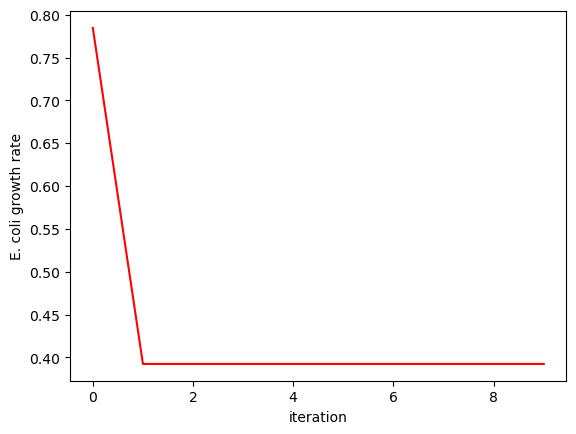

In [37]:
plt.plot(list(F_s[0]['biomass525']),'r')
plt.xlabel('iteration')
plt.ylabel('E. coli growth rate')


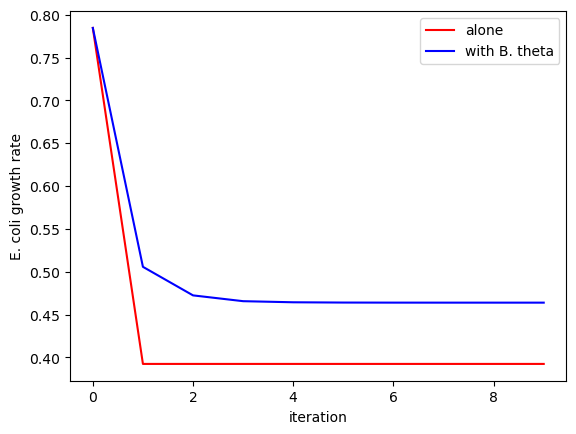

In [38]:
plt.plot(list(F_s[0]['biomass525']),'r')
plt.plot(list(F_p[0]['biomass525']),'b')
plt.xlabel('iteration')
plt.ylabel('E. coli growth rate')
plt.legend(['alone','with B. theta'])

### Example 3: Pairwise w/ Sampling


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import cobra as cb
import numpy as np
import pandas as pd

In [3]:
# model_pre_processing
mod_paths = ['/Users/david/Dropbox/My_Stuff/UVM_2/Lab/Projects/AGORA2_Metabolic_Models/AGORA2_annotatedMat_D_F/Escherichia_coli_str_K_12_substr_MG1655.mat',
             '/Users/david/Dropbox/My_Stuff/UVM_2/Lab/Projects/AGORA2_Metabolic_Models/AGORA2_annotatedMat_A_C/Bacteroides_thetaiotaomicron_3731.mat']
S = [] #list of models
# Load Models and Save in S vector
for i in range(len(mod_paths)):
    model = cb.io.load_matlab_model(mod_paths[i])
    S.append(model) #append models to list

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-14


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [5]:
# Define input environment f_0
# this should be defined as a pandas dataframe with columns "Reaction" and "LB"
# glucose minimal medium
# Define Medium Components
glc_min_med = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_no3(e)','EX_pi(e)','EX_cys_L(e)',
               'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)','EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
glc_min_med_flux = [-10,-100,-100,-100,-100,-100,
                    -100,-100,-100,-100,-100,-100,-100,-100,-100,-100]
glc_f0 = pd.DataFrame(data={'Reaction': glc_min_med,'LB': glc_min_med_flux})

In [6]:
# iterative fba (sampling or non-sampling)
# input/parameters
sol_fun = 'sampling' #sampling or pfba. If pfba, m1 and m2 = 1
f_0 = glc_f0
n = 5 # number of iterations
m1 = 10 # number of initial points to use at each iteration
m2 = 10 # number of runs per initial point
M = np.zeros([m1,n-1],dtype=int) #randomly pre-assign sampling initial point matrix
for i in range(n-1):
    Mcol = np.sort(np.random.choice(m1*m2,m1,replace=False))
    M[:,i]=Mcol
alpha = 0.5
R = [0.5,0.5]

# Function
# output
# initialize environment flux dataframe
# Index
arrays = [[0]*m1*m2,list(range(m1*m2))]
tuples = list(zip(*arrays))
multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
# Columns
cols = set()
for ii in range(len(S)):
    for ji in range(len(S[ii].exchanges)):
        cols.add(S[ii].exchanges[ji].id)
f = pd.DataFrame([np.zeros(len(cols))],columns=list(cols),index=multi_idx,dtype=float)
for ji in range(len(f_0)):
    exid = f_0.iloc[ji]['Reaction']
    ex_flux = f_0.iloc[ji]['LB']
    f.loc[:,exid] = ex_flux

# initialize organism flux dataframes
F = []

for ni in range(n): #iteration
    print('iteration:',ni)
    if ni == 0: #first iteration
        # run fba for each model in environment n
        for ii in range(len(S)):
            print('organism:',ii)
            with S[ii] as model_t: #get model from list of models S
                # Re-set Exchanges (just to be safe)
                for ex in model_t.exchanges:
                    ex.lower_bound = 0
                    ex.upper_bound = 1000
                # Set Environment
                for exi in range(len(f.columns)):
                    ex_lb = f.loc[(0,0)][f.columns[exi]] #initial environment is the same for all runs, so use the 0th run
                    if ex_lb != 0:
                        ex_id = f.columns[exi]
                        if ex_id in model_t.exchanges:
                            model_t.exchanges.get_by_id(ex_id).lower_bound = ex_lb

                if sol_fun == 'pfba':
                    multi_idx = pd.MultiIndex.from_tuples([(0,0)],names=["iteration","run"])                                       
                    # run pFBA
                    sol1 = model_t.slim_optimize()
                    if sol1 > 0.001:
                        sol = cb.flux_analysis.parsimonious.pfba(model_t)
                        # standardize and save output                   
                        df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                        F.append(df)
                    else:
                        rxnid = []
                        for i in range(len(S[ii].reactions)): rxnid.append(S[ii].reactions[i].id)
                        df = pd.DataFrame([np.zeros(len(S[ii].reactions))],columns=rxnid,index=multi_idx)
                        F.append(df)
                
                if sol_fun == 'sampling':
                    # run flux sampling
                    sol = cb.sampling.sample(model_t,m1*m2)
                    # standardize and save output
                    arrays = [[0]*m1*m2,list(sol.index)]
                    tuples = list(zip(*arrays))
                    multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                    sol.index = multi_idx
                    F.append(sol)
            
        # update f
        for mi in range(m1*m2): 
            df_t = f.loc[[(0,0)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
            for ji in range(len(f.columns)):# for each exchange flux in environment
                i_sum = 0
                flux_id = f.columns[ji]
                for ii in range(len(S)):# for each organism sum up flux * relative abundance
                    if flux_id in S[ii].exchanges:
                        if F[ii].loc[(0,mi)][flux_id] != 0:
                            i_sum = i_sum + F[ii].loc[(0,mi)][flux_id] * R[ii]
                df_t.loc[(0,0),flux_id] = (1-alpha)*(f.loc[(0,0)][flux_id].item()-i_sum) + alpha*f.loc[(0,0)][flux_id].item() # update flux
            #re-index tmp dataframe
            multi_idx = pd.MultiIndex.from_tuples([(1,mi)],names=["iteration","run"])
            df_tt = pd.DataFrame([df_t.loc[(0,0)]],columns = df_t.columns, index = multi_idx)
            f = pd.concat([f,df_tt])

    else:
        for m1i in range(m1): #run with different initial points       
            # run fba for each model in environment n set by M matrix
            Mi = M[m1i,ni-1] #mapping
            for ii in range(len(S)):
                print('organism:',ii)
                with S[ii] as model_t: #get model from list of models S
                    # Re-set Exchanges (just to be safe)
                    for ex in model_t.exchanges:
                        ex.lower_bound = 0
                        ex.upper_bound = 1000
                    # Set Environment
                    for exi in range(len(f.columns)):
                        ex_lb = f.loc[(ni,Mi)][f.columns[exi]]
                        if ex_lb != 0:
                            ex_id = f.columns[exi]
                            if ex_id in model_t.exchanges:
                                model_t.exchanges.get_by_id(ex_id).lower_bound = ex_lb
    
                    if sol_fun == 'pfba':
                        multi_idx = pd.MultiIndex.from_tuples([(ni,0)],names=["iteration","run"])
                        # run pFBA
                        sol1 = model_t.slim_optimize()
                        if sol1 > 0.001:
                            sol = cb.flux_analysis.parsimonious.pfba(model_t)
                            # standardize and save output                   
                            df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                            F[ii] = pd.concat([F[ii],df])
                        else:
                            rxnid = []
                            for i in range(len(S[ii].reactions)): rxnid.append(S[ii].reactions[i].id)
                            df = pd.DataFrame([np.zeros(len(S[ii].reactions))],columns=rxnid,index=multi_idx)
                            F[ii] = pd.concat([F[ii],df])
                            
                    if sol_fun == 'sampling':
                        # run flux sampling
                        sol = cb.sampling.sample(model_t,m2)
                        # standardize and save output
                        arrays = [[ni]*m1*m2,list(sol.index+m1i*m2)]
                        tuples = list(zip(*arrays))
                        multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                        sol.index = multi_idx
                        F[ii] = pd.concat([F[ii],sol])

            # update f
            for m2i in range(m2):
                df_t = f.loc[[(ni,Mi)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
                for ji in range(len(f.columns)):# for each exchange flux in environment
                    i_sum = 0
                    flux_id = f.columns[ji]
                    for ii in range(len(S)):# for each organism sum up flux * relative abundance
                        if flux_id in S[ii].exchanges:
                            if F[ii].loc[(ni,m2i+m1i*m2)][flux_id] != 0:
                                i_sum = i_sum + F[ii].loc[(ni,m2i+m1i*m2)][flux_id] * R[ii]
                    df_t.loc[(ni,Mi),flux_id] = (1-alpha)*(f.loc[(ni,Mi)][flux_id].item()-i_sum) + alpha*f.loc[(0,0)][flux_id].item() # update flux
                #re-index tmp dataframe
                multi_idx = pd.MultiIndex.from_tuples([(ni+1,m2i+m1i*m2)],names=["iteration","run"])
                df_tt = pd.DataFrame([df_t.loc[(ni,Mi)]],columns = df_t.columns, index = multi_idx)
                f = pd.concat([f,df_tt])

iteration: 0
organism: 0
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq/T/tmpodzbnyn3.lp
Reading time = 0.02 seconds
: 2630 rows, 6554 columns, 22274 nonzeros
organism: 1
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq/T/tmp0j0id540.lp
Reading time = 0.01 seconds
: 1318 rows, 3010 columns, 11452 nonzeros
iteration: 1
organism: 0
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq/T/tmpgfoqvf4b.lp
Reading time = 0.02 seconds
: 2630 rows, 6554 columns, 22274 nonzeros
organism: 1
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq/T/tmpr8_x0r28.lp
Reading time = 0.01 seconds
: 1318 rows, 3010 columns, 11452 nonzeros
organism: 0
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq/T/tmp1t4djlyu.lp
Reading time = 0.02 seconds
: 2630 rows, 6554 columns, 22274 nonzeros
organism: 1
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gq

In [15]:
# Save F and f with pickle
import pickle
with open('Ff_pair_sample.pkl', 'wb') as file:
    pickle.dump([F,f,M], file)

In [16]:
import pickle
with open('Ff_pair_sample.pkl','rb') as file:
    [F,f,M] = pickle.load(file)

In [17]:
F[0]['biomass525']

iteration  run
0          0      0.011780
           1      0.003948
           2      0.003213
           3      0.003521
           4      0.006598
                    ...   
4          95     0.004245
           96     0.004161
           97     0.004174
           98     0.004237
           99     0.004588
Name: biomass525, Length: 500, dtype: float64

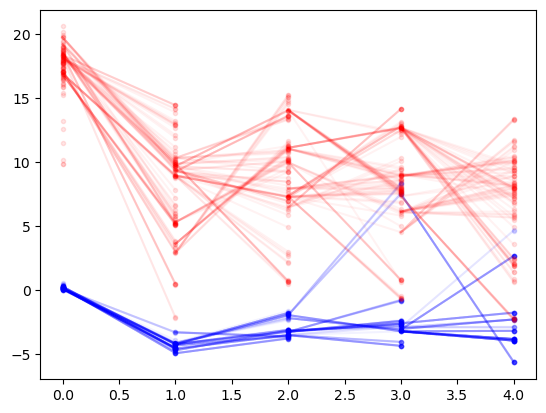

In [75]:
import matplotlib.pyplot as plt

# Plot Sampling Results
org = 0
flux = 'EX_ac(e)'
#flux = 'EX_glc_D(e)'
#flux = 'biomass525'

# First iteration
for j in range(len(F[org][flux][i])):
    plt.plot(0,F[org][flux][0][j],'b.',alpha=0.1)

# N+1 iterations
for i in range(1,M.shape[1]+1):
    #dots for all flux values
    for j in range(len(F[org][flux][i])):
        plt.plot(i,F[org][flux][i][j],'b.',alpha=0.1)
    #lines linking flux values
    for j in range(len(F[org][flux][i])):
        m_ind = M[int(np.floor(j/M.shape[0]))][i-1]
        plt.plot([i-1,i],[F[org][flux][i-1][m_ind],F[org][flux][i][j]],'b-',alpha=0.05)

org = 1
flux = 'EX_ac(e)'
#flux = 'EX_glc_D(e)'
#flux = 'bio1'

# First iteration
for j in range(len(F[org][flux][i])):
    plt.plot(0,F[org][flux][0][j],'r.',alpha=0.1)

# N+1 iterations
for i in range(1,M.shape[1]+1):
    #dots for all flux values
    for j in range(len(F[org][flux][i])):
        plt.plot(i,F[org][flux][i][j],'r.',alpha=0.1)
    #lines linking flux values
    for j in range(len(F[org][flux][i])):
        m_ind = M[int(np.floor(j/M.shape[0]))][i-1]
        plt.plot([i-1,i],[F[org][flux][i-1][m_ind],F[org][flux][i][j]],'r-',alpha=0.05)   

### Other Usefull Code

In [42]:
# Auxotrophy Analysis
exchange = [] # Keep track of exchanges
relative_growth = [] # Keep track of relative growth rate (how well does the model grow without this metabolite vs with the metabolite)

with S[1] as model: # set model

    for ex in model.exchanges: # turn on all exchanges
        ex.lower_bound = -1000
        ex.upper_bound = 1000

    model.exchanges.get_by_id('EX_o2(e)').lower_bound = 0 # turn off oxygen uptake (anaerobic)
    
    base_solution = model.slim_optimize() # calculate the base growth rate, with all nutrients available, using FBA
    if base_solution < 0.01: # print a warning if the model didn't grow with all nutrients
        print('base solution low')
        
    for ex in model.exchanges: # for each exchange reaction
        ex_id = ex.id
        
        with model as model1: 
            model1.reactions.get_by_id(ex_id).lower_bound = 0 # turn off uptake
            aux_solution = model.slim_optimize() # recalculate growth rate
            rel_gro = (aux_solution-base_solution)/base_solution # calculate relative growth change
            exchange.append(ex_id) # save exchange id
            relative_growth.append(rel_gro) # save relative growth change

# Save essential metabolite ids for late (these are the metabolites that when removed cause a greater than 90% reduction in growth)
essential_inds = np.argwhere(np.array(relative_growth)<-0.9)
essentials = np.array(exchange)[essential_inds]

essentials

array([['EX_ca2(e)'],
       ['EX_cl(e)'],
       ['EX_cobalt2(e)'],
       ['EX_cu2(e)'],
       ['EX_cys_L(e)'],
       ['EX_fe2(e)'],
       ['EX_k(e)'],
       ['EX_mg2(e)'],
       ['EX_mn2(e)'],
       ['EX_pi(e)'],
       ['EX_zn2(e)']], dtype='<U19')

In [57]:
# Minimal Medium
with S[1] as model_t:
    # add reactions that minimal media doesn't know about
    add_ex = ['ac[c]','so4[c]','nh4[c]','pi[c]']
    for ex in add_ex:
        F_rxn = cb.Reaction('F_'+ex)
        F_rxn.lower_bound = -100
        F_rxn.upper_bound = 1000
        F_rxn.add_metabolites({model_t.metabolites.get_by_id(ex):-1})
        model_t.add_reactions([F_rxn])
    med1 = cb.medium.minimal_medium(model_t,0.01,open_exchanges=True,minimize_components=3)
med2 = cb.medium.minimal_medium(S[1],0.01,open_exchanges=True,minimize_components=3)


In [59]:
med1

EX_ca2(e)             0.000079
EX_cl(e)              0.000079
EX_cobalt2(e)         0.000079
EX_cu2(e)             0.000079
EX_cys_L(e)           0.002102
EX_fe2(e)             0.000318
EX_k(e)               0.000079
EX_mg2(e)             0.000079
EX_mn2(e)             0.000079
EX_pullulan1200(e)    0.000215
EX_zn2(e)             0.000079
dtype: float64

In [60]:
med2

EX_ca2(e)        0.000079
EX_cl(e)         0.000079
EX_cobalt2(e)    0.000079
EX_cu2(e)        0.000079
EX_cys_L(e)      0.002102
EX_fe2(e)        0.000318
EX_hspg(e)       0.067659
EX_k(e)          0.000079
EX_mg2(e)        0.000079
EX_mn2(e)        0.000079
EX_pi(e)         0.006189
EX_zn2(e)        0.000079
dtype: float64